# Tổng quan
## Tệp dữ liệu
Tệp dữ liệu được sử dụng là một mẫu dữ liệu về lịch sử đơn hàng của doanh nghiệp trong khoảng thời gian từ ngày 4/1/2019 đến ngày 31/12/2022, dữ liệu có kích thước 5009 đơn hàng với 793 khách hàng. Các biến của dữ liệu bao gồm:
* **ngay_dat_mua**: ngày đặt hàng
* **ma_don_hang**: mã đơn hàng
* **khach_hang**: tên khách hàng
* **tong_gia_tri_hang**: tổng số tiền của đơn hàng

## Phương pháp phân đoạn RFM
**Phương pháp Elbow**
phương pháp này sẽ tính toán tổng bình phương khoảng cách của các điểm dữ liệu đến tâm cụm gần nhất và chọn số cụm K sao cho giá trị này giảm dần đến một mức độ nào đó. Giá trị K tương ứng với điểm giảm mạnh nhất trên đồ thị sẽ được chọn làm số cụm K của mô hình. Việc phân cụm sẽ được thực hiện bằng thuật toán K - Means

**Phương pháp ngũ phân vị**
Từ giá trị R - F - M của từng khách hàng, ta quy đổi các giá trị này theo thang đo từ 1 đến 5. Kết quả sẽ được tổng hợp lại thành điểm RFM và dựa vào đó, khách hàng được chia thành 11 phân khúc



# Thực hiện tính toán RFM bằng Python


## Khai báo các thư viện

In [11]:
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## Lấy dữ liệu khách hàng từ file csv

In [12]:
df = pd.read_csv("sample-orders.csv", sep=',', encoding="windows-1252")

chuyển đổi dữ liệu ngày tháng từ dạng chuỗi thành datetime object

In [13]:
df['ngay_dat_mua'] = pd.to_datetime(df['ngay_dat_mua'])
NOW = datetime.strptime("2022-12-31", "%Y-%m-%d")

## Tính các giá trị R - F - M từ dữ liệu khách hàng

In [14]:
bang_rfm = df.groupby('khach_hang').agg({'ngay_dat_mua': lambda x: (NOW - x.max()).days,  # Recency
                                         'ma_don_hang': lambda x: len(x),  # Frequency
                                         'tong_gia_tri_hang': lambda x: x.sum()}) # Monetary

# Đổi tên cột thành recency, frequency và monetary
bang_rfm.rename(columns={'ngay_dat_mua': 'recency',
                         'ma_don_hang': 'frequency',
                         'tong_gia_tri_hang': 'monetary'}, inplace=True)

bang_rfm.head()

,recency,frequency,monetary
khach_hang,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249


## Mô tả dữ liệu bằng biểu đồ 3D

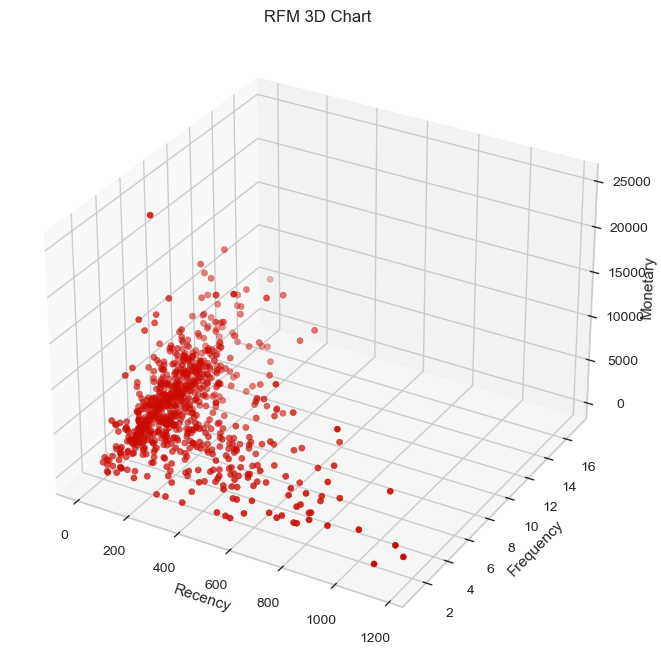

In [28]:
import matplotlib.pyplot as plt
# Vẽ biểu đồ 3D cho các giá trị R,F,M
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bang_rfm['recency'],bang_rfm['frequency'],bang_rfm['monetary'])

# Thêm nhãn cho các trục
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Đặt tên cho biểu đồ
plt.title('RFM 3D Chart')
# Hiển thị biểu đồ
plt.show()

# Phân cụm K - Means theo Phương pháp Elbow


## khai báo thư viện

In [16]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Tính số cụm K



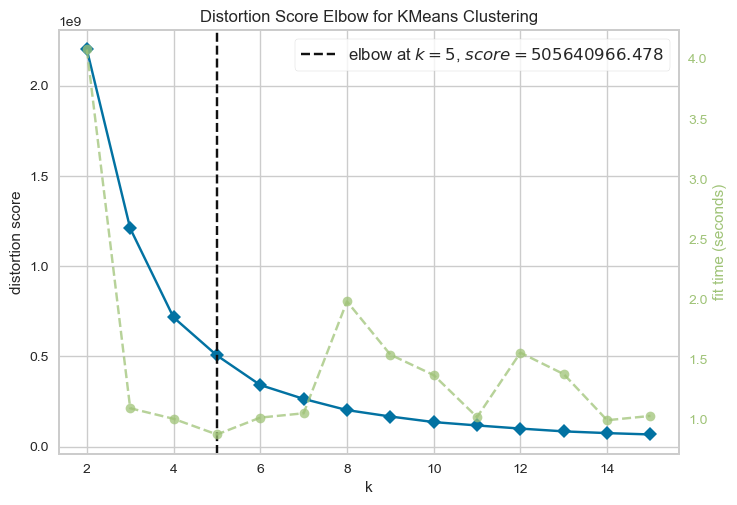

5

In [17]:
df_rfm = bang_rfm[['recency','frequency','monetary']]

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans,k=15)
elbow.fit(df_rfm)
elbow.show()

elbow.elbow_value_

Giá trị trung tâm của từng cụm

In [18]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_rfm)

kmeans.cluster_centers_

array([[1.23890511e+02, 7.00000000e+00, 2.84173723e+03],
       [1.40375000e+02, 7.12500000e+00, 1.61838750e+04],
       [1.88494186e+02, 4.92441860e+00, 1.00434884e+03],
       [1.35043478e+02, 8.50000000e+00, 8.97293478e+03],
       [8.50743802e+01, 7.84297521e+00, 5.21407438e+03]])

## Phân cụm KMeans

In [19]:
clusters = kmeans.labels_
df_rfm = bang_rfm[['recency','frequency','monetary']]
df_rfm["Phan_cum_KMeans"] = clusters
df_rfm["Phan_cum_KMeans"] = df_rfm["Phan_cum_KMeans"] + 1

df_rfm.to_csv('output.csv',sep=',')
df_rfm.head()

,recency,frequency,monetary,Phan_cum_KMeans
khach_hang,,,,
Aaron Bergman,415,3,887,3
Aaron Hawkins,12,7,1744,3
Aaron Smayling,88,7,3050,1
Adam Bellavance,54,8,7756,4
Adam Hart,34,10,3249,1


## Biểu đồ mô tả

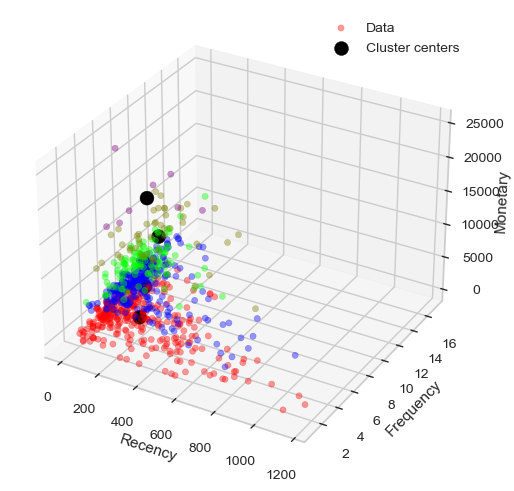

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_rfm.recency, df_rfm.frequency, df_rfm.monetary, c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = 'black', s=100, alpha=1)

plt.legend(['Data','Cluster centers'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

# Phân cụm theo điểm RFM trên thang 5-5-5


## Tính ngũ phân vị của R - F - M

In [21]:
ngu_phan_vi = bang_rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
print(ngu_phan_vi)
ngu_phan_vi = ngu_phan_vi.to_dict()

     recency  frequency  monetary
0.2     26.0        4.0     961.4
0.4     53.0        5.0    1739.8
0.6    103.0        7.0    2750.8
0.8    224.6        8.6    4282.6


## Tạo hàm phân loại R - F - M  theo thang 5

In [22]:
def ngu_phan_vi_recency(x, p, d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 2
    else:
        return 1

def ngu_phan_vi_frequency_monetary(x, p, d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

## Tiến hành phân loại và đưa kết quả vào cột mới

In [23]:
phan_doan_khach_hang = bang_rfm

phan_doan_khach_hang['ngu_phan_vi_R'] = phan_doan_khach_hang['recency'].apply(ngu_phan_vi_recency,
                                                                              args=('recency', ngu_phan_vi,))

phan_doan_khach_hang['ngu_phan_vi_F'] = phan_doan_khach_hang['frequency'].apply(ngu_phan_vi_frequency_monetary,
                                                                                args=('frequency', ngu_phan_vi,))

phan_doan_khach_hang['ngu_phan_vi_M'] = phan_doan_khach_hang['monetary'].apply(ngu_phan_vi_frequency_monetary,
                                                                               args=('monetary', ngu_phan_vi,))

## Tổng hợp kết quả lại thành điểm RFM

In [24]:
phan_doan_khach_hang['Diem_RFM'] = phan_doan_khach_hang['ngu_phan_vi_R'].map(str) + \
                                   phan_doan_khach_hang['ngu_phan_vi_F'].map(str) + \
                                   phan_doan_khach_hang['ngu_phan_vi_M'].map(str)

df_thang5 = df_rfm
df_thang5['Diem_RFM'] = phan_doan_khach_hang['Diem_RFM']
df_thang5.head()

,recency,frequency,monetary,Phan_cum_KMeans,Diem_RFM
khach_hang,,,,,
Aaron Bergman,415,3,887,3,111
Aaron Hawkins,12,7,1744,3,533
Aaron Smayling,88,7,3050,1,334
Adam Bellavance,54,8,7756,4,345
Adam Hart,34,10,3249,1,454


## Phân cụm dựa trên điểm RFM

In [25]:
def segment(x):
  if x in ['555', '554', '544', '545', '454', '455', '445']:
      return 'Champions'
  elif x in ['543', '444', '435', '355', '354', '345', '344', '335']:
      return 'Loyal'
  elif x in ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']:
      return 'Potential Loyalist'
  elif x in ['512', '511', '422', '421', '412', '411', '311']:
      return 'New Customers'
  elif x in ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']:
      return 'Promising'
  elif x in ['535', '534', '443', '434', '343', '334', '325', '324']:
      return 'Need Attention'
  elif x in ['331', '321', '312', '221', '213', '231', '241', '251']:
      return 'About To Sleep'
  elif x in ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']:
      return "At Risk"
  elif x in ['155', '154', '144', '214', '215', '115', '114', '113']:
      return 'Cannot Lose Them'
  elif x in ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211']:
      return 'Hibernating Customers'
  else:
      return 'Lost Customers'

df_thang5['Phan_cum_thang_5'] = df_rfm['Diem_RFM'].apply(segment)
df_thang5.to_csv("output.csv")
df_thang5.head()

,recency,frequency,monetary,Phan_cum_KMeans,Diem_RFM,Phan_cum_thang_5
khach_hang,,,,,,
Aaron Bergman,415,3,887,3,111,Lost Customers
Aaron Hawkins,12,7,1744,3,533,Potential Loyalist
Aaron Smayling,88,7,3050,1,334,Need Attention
Adam Bellavance,54,8,7756,4,345,Loyal
Adam Hart,34,10,3249,1,454,Champions


## Biểu đồ mô tả

Phan_cum_thang_5
Potential Loyalist       118
At Risk                  105
Hibernating Customers     99
Champions                 80
Lost Customers            76
Need Attention            71
Loyal                     63
New Customers             59
Promising                 52
About To Sleep            42
Cannot Lose Them          28
Name: count, dtype: int64


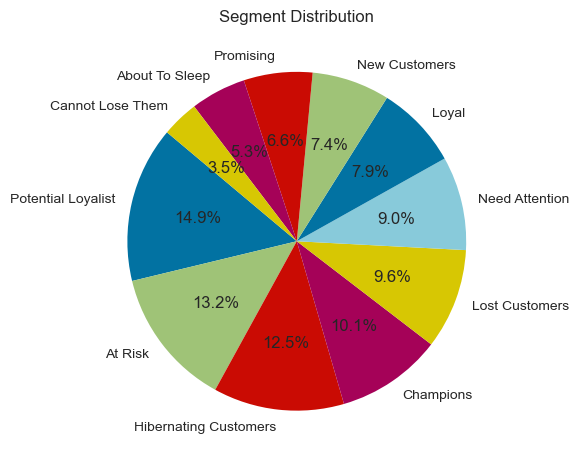

In [29]:
segment_counts = df_thang5['Phan_cum_thang_5'].value_counts()
print(segment_counts)

plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Segment Distribution')

plt.show()